# IDS Assignment 5 – Computer Vision

To work in this Colab notebook, first save a copy of it via "File" -> "Save a copy in Drive" in the top-left menu bar.


### 1. Install all missing packages that we need an download our custom FashionMNIST data

The data files will be available locally in your Colab runtime. You can find them through the files menu on the left.

In [2]:
# Install packages
!pip install torchmetrics gdown

# Download training, validation, and test splits
!gdown https://drive.google.com/uc?id=1zYfBlExr_LK-Ld8rmxCTqRU5RAOUVVfh
!gdown https://drive.google.com/uc?id=1PJa_I3qG0P5whuARV_Se1_YUvHzR469R
!gdown https://drive.google.com/uc?id=1pC8-ummMGy1dPhHGPuNsms5_I7HpWgv2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

### 2. Import classes and functions we will be using

In [3]:
import math
import os
import random
from typing import Any, Callable, Optional, Tuple

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from PIL import Image
from tqdm import tqdm

import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import SGD
from torch.optim.lr_scheduler import LinearLR
from torch.utils.data import DataLoader
from torchvision.datasets import VisionDataset
from torchvision.transforms import Compose, Lambda, ToTensor
from torchvision.models.resnet import ResNet, BasicBlock
from torchmetrics.functional.classification import multiclass_confusion_matrix

### 3. Check which PyTorch version we are running and confirm that we are in a GPU runtime.
If this output shows that you are not in a GPU runtime, go to "Runtime" in the top-left menu bar -> "Change runtime type" -> set "Hardware Accelerator: GPU".

In [4]:
print(f"Running PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
!nvidia-smi

Running PyTorch version: 2.2.1+cu121
CUDA available: True
Mon Apr  8 11:25:50 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+---------

### 4. Make things (more) reproducible by setting random seeds

See here for details: https://pytorch.org/docs/stable/notes/randomness.html

In [5]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

### 5. Define our custom IDS FashionMNIST PyTorch dataset

Our model inherits, i.e. is a specific kind of, `VisionDataset` in torchvision.\
This means it has all features defined in `VisionDataset`, unless they are explicitly overridden here, \
plus any additional functionality that may be defined below. You can read more about `VisionDataset` here: https://pytorch.org/vision/main/generated/torchvision.datasets.VisionDataset.html.

In [6]:
class IDSFashionMnistDataset(VisionDataset):
    """
    FashionMNIST dataset for the IDS course which loads custom data files from disk
    """

    classes = [
        "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
        "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
    ]

    def __init__(
        self,
        root: str,
        split: str = "training",
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
    ) -> None:
        super().__init__(root, transform=transform, target_transform=target_transform)

        if not split in ["training", "validation", "test"]:
            raise ValueError("Split should be 'training', 'validation', or 'test'.")

        self.split = split
        self.root = root

        self.data, self.targets = self._load_data()

    def _load_data(self):
        data = torch.load(os.path.join(self.root, f"fashion_mnist_{self.split}.pt"))
        images = data[:, :-1].reshape(-1, 28, 28)  # 28x28 resolution
        labels = data[:, -1]
        return images, labels

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], int(self.targets[index])

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img.numpy(), mode="L")

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.data)

### 6. Define our custom ResNet-18 model for FashionMNIST
The original ResNet-18 uses 3-channel (RGB) inputs and has 1000 output classes based on ImageNet-1K.

https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html

We instead use single-channel inputs (Grayscale) and 10 output classes according to FashionMNIST.

In [7]:
class FashionMnistResNet18(ResNet):
    """
    Custom ResNet-18 model which uses 1 input channel (grayscale) and has 10 output classes
    """
    def __init__(self):
        super().__init__(BasicBlock, [2,2,2,2,2], num_classes=10)
        self.conv1 = nn.Conv2d(1, 64,
          kernel_size=(7, 7),
          stride=(2, 2),
          padding=(3, 3),
          bias=False
        )

### 7. Load our custom FashionMNIST data

Here, we load our data using the `IDSFashionMnistDataset` class defined above. We also make use of the functionality in torchvision's `VisionDataset`, which `IDSFashionMnistDataset` inherits from, to set the transformations we want to apply when retrieving examples from our dataset. We use the `transform` keyword argument for this and compose our transformations using torchvision's `Compose` (https://pytorch.org/vision/main/generated/torchvision.transforms.Compose.html). In our base setting, the only transformation we apply is `ToTensor`, which converts our `PIL.Image` inputs into PyTorch tensors.

In [8]:
# Create base transformation for our dataset
# TODO: how can these be modified to randomly flip examples?
from torchvision.transforms import RandomHorizontalFlip, RandomVerticalFlip

base_transform = Compose([
    ToTensor(),
    RandomHorizontalFlip(),  # Randomly flip the input horizontally with a probability of 0.5
    RandomVerticalFlip(),    # Randomly flip the input vertically with a probability of 0.5
])

# Load datasets
train_dataset = IDSFashionMnistDataset(".", "training", transform=base_transform)
validation_dataset = IDSFashionMnistDataset(".", "validation", transform=base_transform)
test_dataset = IDSFashionMnistDataset(".", "test", transform=base_transform)

# Check the sizes of our datasets
print(f"Training dataset length = {len(train_dataset)}")
print(f"Validation dataset length = {len(validation_dataset)}")
print(f"Test dataset length = {len(test_dataset)}")

Training dataset length = 5000
Validation dataset length = 1000
Test dataset length = 1000


### 8. Implement our evaluation function and training loop

Below, we provide some rudimentary functionality for training and evaluation,\
as well as metric storing and logging, for our experiments.

In [9]:
def log_metrics(metrics: dict, step: Optional[int] = None):
    """
    Log metrics stored in a dictionary
    """

    # During training, it can be useful to also log the current step
    if step is not None:
        print(f"\nMetrics step {step}:")

    for k, v in metrics.items():
        # We ignore the confusion matrix when logging metrics
        if not k.endswith("conf_matrix"):
            print(f"  {k}: {v}")

def evaluate(model, eval_dataloader, prefix="eval"):
    """
    Evaluation function that computes the loss, accuracy, and confusion matrix for the dataset
    passed via the `eval_dataloader` argument
    """

    # Define loss function
    criterion = nn.CrossEntropyLoss()

    # Move model to GPU
    model.cuda()

    # Set model to evaluation mode (e.g. to disable dropout)
    model.eval()

    eval_loss = 0
    y_pred = None
    y_true = None
    num_classes = None

    for batch_idx, batch in enumerate(tqdm(eval_dataloader, desc=f"Evaluating")):
        # Loop over batches in dataloader

        # Move batch to GPU
        inputs, labels = batch
        inputs = inputs.cuda()
        labels = labels.cuda()

        # Use no_grad mode to disable gradient computation
        with torch.no_grad():
            # Get model outputs
            outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels)
        eval_loss += loss.detach().cpu().item()

        if num_classes is None:
            num_classes = len(outputs[0])

        # Get class predictions
        preds = torch.argmax(outputs, dim=-1)

        # Accumulate predictions and true classes over batches
        y_pred = torch.cat([y_pred, preds]) if y_pred is not None else preds
        y_true = torch.cat([y_true, labels]) if y_true is not None else labels


    # Move predictions and true classes back to CPU
    y_pred = y_pred.detach().cpu()
    y_true = y_true.detach().cpu()

    # Compute metrics
    eval_loss /= len(eval_dataloader)
    eval_acc = (y_pred == y_true).sum() / len(y_true)
    eval_conf_matrix = multiclass_confusion_matrix(
        y_pred, y_true, num_classes=num_classes
    )

    # Store metrics in a dictionary
    metrics = {
        f"{prefix}_loss": eval_loss,
        f"{prefix}_accuracy": eval_acc.item(),
        f"{prefix}_conf_matrix": eval_conf_matrix.numpy()
    }

    return metrics


def save_best_model(model: nn.Module):
  """
  Simple function that saves the weights of the specified model to disk.
  We use this to keep track of the best model (based on validation loss).
  """
  output_path = "best_model.pt"
  torch.save(model.state_dict(), output_path)
  print(f"Saved new best model to {output_path}\n")


def load_best_model(model: nn.Module, model_path: str = "best_model.pt"):
  """
  Simple function that loads model weights stored at `model_path` into the
  passed model of type `nn.Module`. We use this to load our best model checkpoint.
  """
  model.load_state_dict(torch.load(model_path))
  model.eval()
  print(f"Loaded best {model.__class__.__name__} model from {model_path}\n")
  return model


def train(
  model: nn.Module,
  train_dataloader: DataLoader,
  eval_dataloader: DataLoader,
  num_epochs: int = 20,
  lr: float = 0.1,
  eval_steps: int = 100
):
    """
    Training loop
    """

    # Create SGD optimizer with specified learning rate and fixed momentum
    optimizer = SGD(model.parameters(), lr=lr, momentum=0.9)

    # Create linear learning rate decay schedule
    scheduler = LinearLR(
        optimizer,
        start_factor=1.0,
        end_factor=1e-6,
        total_iters=len(train_dataloader) * num_epochs
    )

    # Define loss function
    criterion = nn.CrossEntropyLoss()

    # Move model to GPU
    model.cuda()

    total_loss = 0
    total_eval_loss = 0
    global_step = 0
    global_eval_step = 0
    best_eval_loss = float("inf")

    # Store our initial model
    save_best_model(model)

    # Create dictionary to store metrics throughout training
    metrics_dict = {}

    print("Starting model training")

    for epoch_idx in range(num_epochs):
        # Epoch loop (one epoch is one pass over the full training dataset)

        for batch_idx, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch_idx+1}")):
            # Loop over batches in training dataset

            # Set model to training mode
            model.train()

            global_step += 1

            # Move batch to GPU
            inputs, labels = batch
            inputs = inputs.cuda()
            labels = labels.cuda()

            # Get model outputs
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)
            total_loss += loss.detach().cpu().item()

            # Evaluation loop
            if global_step % eval_steps == 0:
                global_eval_step += 1
                metrics = {
                    "mean_train_loss": total_loss / global_step,
                    "learning_rate": scheduler.get_last_lr()[0]
                }

                # Evaluate on validation and training datasets
                metrics.update(evaluate(model, eval_dataloader, prefix="eval"))
                metrics.update(evaluate(model, train_dataloader, prefix="train"))

                # Update and log metrics
                total_eval_loss += metrics["eval_loss"]
                metrics["mean_eval_loss"] = total_eval_loss / global_eval_step
                log_metrics(metrics, step=global_step)
                metrics_dict[global_step] = metrics

                # Check if our validation loss has decreased, and if so,
                # update our best model checkpoint
                if metrics["eval_loss"] <= best_eval_loss:
                  best_eval_loss = metrics["eval_loss"]
                  save_best_model(model)

            # Compute gradients
            loss.backward()

            # Perform update step
            optimizer.step()

            # Reduce learning rate for stability
            scheduler.step()

            # Set gradients to zero
            model.zero_grad()

    return metrics_dict

### 9. Define hyperparameters, create dataloaders, instantiate model, and run training/evaluation procedure

Here, we set our hyper-parameters for the dataloader (batch size) and the training loop \
(number of epochs, learning rate, and evaluation interval in steps).

We only use very basic data loading functionality. More information on available features can be found here https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader.

In [10]:
# TODO: set your hyperparameters
bs = 256
num_epochs = 100
lr = 0.1
eval_steps = 100

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=bs, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=bs, shuffle=False)

# Instantiate a new model
model = FashionMnistResNet18()

# Train model and save training and evaluation metrics
metrics_dict = train(
    model, train_dataloader, validation_dataloader, num_epochs=num_epochs, lr=lr, eval_steps=eval_steps
)

Saved new best model to best_model.pt

Starting model training


Evaluating: 100%|██████████| 4/4 [00:00<00:00,  4.63it/s]

Evaluating: 100%|██████████| 20/20 [00:03<00:00,  6.47it/s]



Metrics step 100:
  mean_train_loss: 0.9978085085749626
  learning_rate: 0.09505000494999999
  eval_loss: 0.628149539232254
  eval_accuracy: 0.7760000228881836
  train_loss: 0.5720622301101684
  train_accuracy: 0.7766000032424927
  mean_eval_loss: 0.628149539232254


Epoch 5: 100%|██████████| 20/20 [00:07<00:00,  2.78it/s]


Saved new best model to best_model.pt



Evaluating: 100%|██████████| 4/4 [00:00<00:00, 14.15it/s]

Epoch 10: 100%|██████████| 20/20 [00:03<00:00,  6.12it/s]



Metrics step 200:
  mean_train_loss: 0.7397679196298123
  learning_rate: 0.09005000994999993
  eval_loss: 0.7202093750238419
  eval_accuracy: 0.7670000195503235
  train_loss: 0.6575311779975891
  train_accuracy: 0.7724000215530396
  mean_eval_loss: 0.6741794571280479


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 17.16it/s]

Epoch 15: 100%|██████████| 20/20 [00:02<00:00,  6.91it/s]



Metrics step 300:
  mean_train_loss: 0.6205130034685135
  learning_rate: 0.08505001494999989
  eval_loss: 0.5469987615942955
  eval_accuracy: 0.8140000104904175
  train_loss: 0.36473190039396286
  train_accuracy: 0.8629999756813049
  mean_eval_loss: 0.6317858919501305
Saved new best model to best_model.pt



Evaluating: 100%|██████████| 4/4 [00:00<00:00, 17.56it/s]

Epoch 20: 100%|██████████| 20/20 [00:02<00:00,  7.29it/s]



Metrics step 400:
  mean_train_loss: 0.540525510981679
  learning_rate: 0.08005001994999977
  eval_loss: 0.5541816428303719
  eval_accuracy: 0.8090000152587891
  train_loss: 0.33656693547964095
  train_accuracy: 0.8795999884605408
  mean_eval_loss: 0.6123848296701908


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 16.91it/s]

Epoch 25: 100%|██████████| 20/20 [00:03<00:00,  6.37it/s]



Metrics step 500:
  mean_train_loss: 0.4840520966053009
  learning_rate: 0.07505002494999956
  eval_loss: 0.5351733043789864
  eval_accuracy: 0.8309999704360962
  train_loss: 0.25906178280711173
  train_accuracy: 0.9043999910354614
  mean_eval_loss: 0.59694252461195
Saved new best model to best_model.pt



Evaluating: 100%|██████████| 4/4 [00:00<00:00, 17.36it/s]

Epoch 30: 100%|██████████| 20/20 [00:03<00:00,  6.63it/s]



Metrics step 600:
  mean_train_loss: 0.4377129411449035
  learning_rate: 0.07005002994999944
  eval_loss: 0.5762365683913231
  eval_accuracy: 0.8410000205039978
  train_loss: 0.17359877116978167
  train_accuracy: 0.9372000098228455
  mean_eval_loss: 0.5934915319085121


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 17.82it/s]

Epoch 35: 100%|██████████| 20/20 [00:02<00:00,  6.89it/s]



Metrics step 700:
  mean_train_loss: 0.40006825107548916
  learning_rate: 0.06505003494999935
  eval_loss: 0.5348154455423355
  eval_accuracy: 0.8420000076293945
  train_loss: 0.14611856155097486
  train_accuracy: 0.9462000131607056
  mean_eval_loss: 0.5851092338562012
Saved new best model to best_model.pt



Evaluating: 100%|██████████| 4/4 [00:00<00:00, 17.80it/s]

Epoch 40: 100%|██████████| 20/20 [00:02<00:00,  7.28it/s]



Metrics step 800:
  mean_train_loss: 0.3671823501773179
  learning_rate: 0.06005003994999934
  eval_loss: 0.5824903547763824
  eval_accuracy: 0.8370000123977661
  train_loss: 0.1067498441785574
  train_accuracy: 0.9661999940872192
  mean_eval_loss: 0.5847818739712238


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 11.01it/s]

Epoch 45: 100%|██████████| 20/20 [00:03<00:00,  6.28it/s]



Metrics step 900:
  mean_train_loss: 0.3395046124069227
  learning_rate: 0.055050044949999356
  eval_loss: 0.6214809715747833
  eval_accuracy: 0.8339999914169312
  train_loss: 0.13660726100206375
  train_accuracy: 0.9506000280380249
  mean_eval_loss: 0.5888595514827304


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 17.17it/s]

Epoch 50: 100%|██████████| 20/20 [00:02<00:00,  7.14it/s]



Metrics step 1000:
  mean_train_loss: 0.31594533811882136
  learning_rate: 0.050050049949999446
  eval_loss: 0.6577443331480026
  eval_accuracy: 0.8379999995231628
  train_loss: 0.0954634353518486
  train_accuracy: 0.9635999798774719
  mean_eval_loss: 0.5957480296492577


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 19.28it/s]

Epoch 55: 100%|██████████| 20/20 [00:02<00:00,  7.25it/s]



Metrics step 1100:
  mean_train_loss: 0.29378265044059265
  learning_rate: 0.045050054949999536
  eval_loss: 0.7470927536487579
  eval_accuracy: 0.8370000123977661
  train_loss: 0.06616217866539956
  train_accuracy: 0.9757999777793884
  mean_eval_loss: 0.6095066409219395


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 17.66it/s]

Epoch 60: 100%|██████████| 20/20 [00:02<00:00,  7.12it/s]



Metrics step 1200:
  mean_train_loss: 0.27375046550451465
  learning_rate: 0.04005005994999966
  eval_loss: 0.7338097393512726
  eval_accuracy: 0.8519999980926514
  train_loss: 0.037878690846264364
  train_accuracy: 0.9873999953269958
  mean_eval_loss: 0.6198652324577173


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 12.39it/s]

Epoch 65: 100%|██████████| 20/20 [00:03<00:00,  6.03it/s]



Metrics step 1300:
  mean_train_loss: 0.2557737195620743
  learning_rate: 0.03505006494999977
  eval_loss: 0.7977392971515656
  eval_accuracy: 0.8420000076293945
  train_loss: 0.03685176516883075
  train_accuracy: 0.9879999756813049
  mean_eval_loss: 0.6335478528187826


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 17.34it/s]

Epoch 70: 100%|██████████| 20/20 [00:02<00:00,  6.91it/s]



Metrics step 1400:
  mean_train_loss: 0.23955867084674537
  learning_rate: 0.030050069949999845
  eval_loss: 0.8125537633895874
  eval_accuracy: 0.8519999980926514
  train_loss: 0.02748350859619677
  train_accuracy: 0.9909999966621399
  mean_eval_loss: 0.6463339892881257


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 18.27it/s]

Epoch 75: 100%|██████████| 20/20 [00:02<00:00,  7.12it/s]



Metrics step 1500:
  mean_train_loss: 0.22451098327773314
  learning_rate: 0.025050074949999862
  eval_loss: 0.9644861668348312
  eval_accuracy: 0.847000002861023
  train_loss: 0.01230389274423942
  train_accuracy: 0.9968000054359436
  mean_eval_loss: 0.6675441344579061


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 18.13it/s]

Epoch 80: 100%|██████████| 20/20 [00:02<00:00,  7.12it/s]



Metrics step 1600:
  mean_train_loss: 0.21084244749952633
  learning_rate: 0.02005007994999987
  eval_loss: 0.9421664625406265
  eval_accuracy: 0.8579999804496765
  train_loss: 0.004070159269031137
  train_accuracy: 0.9990000128746033
  mean_eval_loss: 0.6847080299630761


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 10.72it/s]

Epoch 85: 100%|██████████| 20/20 [00:03<00:00,  6.23it/s]



Metrics step 1700:
  mean_train_loss: 0.19879345492607065
  learning_rate: 0.015050084949999864
  eval_loss: 1.0334956496953964
  eval_accuracy: 0.847000002861023
  train_loss: 0.002074509079102427
  train_accuracy: 1.0
  mean_eval_loss: 0.7052249487708596


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 17.27it/s]

Epoch 90: 100%|██████████| 20/20 [00:02<00:00,  6.96it/s]



Metrics step 1800:
  mean_train_loss: 0.18789381673414027
  learning_rate: 0.010050089949999917
  eval_loss: 1.0228511095046997
  eval_accuracy: 0.8519999980926514
  train_loss: 0.0012025767471641302
  train_accuracy: 1.0
  mean_eval_loss: 0.7228708465894064


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 17.32it/s]

Epoch 95: 100%|██████████| 20/20 [00:02<00:00,  7.02it/s]



Metrics step 1900:
  mean_train_loss: 0.17810181030828973
  learning_rate: 0.005050094949999962
  eval_loss: 1.0214805006980896
  eval_accuracy: 0.8450000286102295
  train_loss: 0.0007996310319867917
  train_accuracy: 1.0
  mean_eval_loss: 0.7385871441740739


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 17.22it/s]

Epoch 100: 100%|██████████| 20/20 [00:02<00:00,  7.02it/s]


Metrics step 2000:
  mean_train_loss: 0.16926644727704115
  learning_rate: 5.009994999999962e-05
  eval_loss: 0.9796757102012634
  eval_accuracy: 0.8569999933242798
  train_loss: 0.0007883651123847812
  train_accuracy: 1.0
  mean_eval_loss: 0.7506415724754334


### 10. Load our saved best model checkpoint

We can make use of the `load_best_model` function defined above to quickly load \
the best model checkpoint for further evaluation.

You can find more information on saving and loading model weights at

https://pytorch.org/tutorials/beginner/saving_loading_models.html.

In [11]:
best_model = load_best_model(FashionMnistResNet18())

Loaded best FashionMnistResNet18 model from best_model.pt



### 11. Evaluate your best model and visualize the confusion matrix

TODO: You should implement this yourself using the functions defined above.

Evaluating: 100%|██████████| 4/4 [00:00<00:00,  5.78it/s]


Test accuracy: 0.8569999933242798



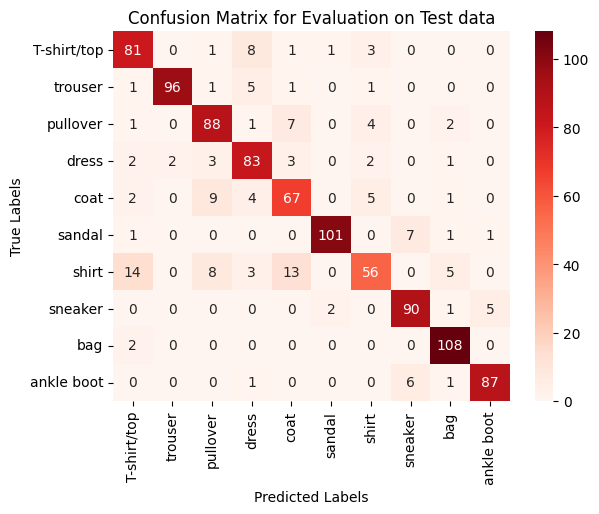

In [15]:

test_metric = evaluate(best_model, test_dataloader)

#print(test_metric)
conf_matrix = test_metric["eval_conf_matrix"] # get confusion matrix
eval_loss = test_metric["eval_loss"] # get evaluation loss
eval_accuracy = test_metric["eval_accuracy"] # get evaluation accuracy

# get test accuracy of model at best validation loss:

#learning_step, min_mean_eval_loss = min(metrics_dict.items(), key=lambda x: x[1]['mean_eval_loss']) # get minimum mean evaluation loss from training metric
test_accuracy = eval_accuracy # test accuracy at best validation loss
print("Test accuracy: " + str(test_accuracy))
print("")
# visualize confusion matrix

ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
ax.set(ylabel= 'True Labels', xlabel= 'Predicted Labels', title='Confusion Matrix for Evaluation on Test data')

classes = ['T-shirt/top','trouser','pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
ax.set_xticklabels(classes,rotation=90)
ax.set_yticklabels(classes,rotation=0)
plt.show()

#### Discussion of confusion matrix:

The confusion matrix shows the the true labels and the labels predicted by the model. By seeing the model's correct and false predictions, we get an overview of the model's performance. The model's correct classifications can be seen in the diagonal. Generally, the model predicts all labels well (above chance classification would be > data_for_one_class/num_classes and in all cases this is reached). Especially the 'bag' category gets predicted well (108 correct vs 2 incorrect classifications). The category 'shirt' however is where the model struggles the most. The label gets predicted correctly in 56 cases, but gets confounded as 't-shirt' in 14 cases and as pullover in 8 cases. This is likely due to the similar appearances of shirts and t-shirt/tops.

The test accuracy for our best model is 0.8569999933242798, so very high as we are aiming for an accuracy of max. 100.

### 12. Plot your loss curves

TODO: You should implement this yourself. Use the `metrics_dict` returned by the training loop.

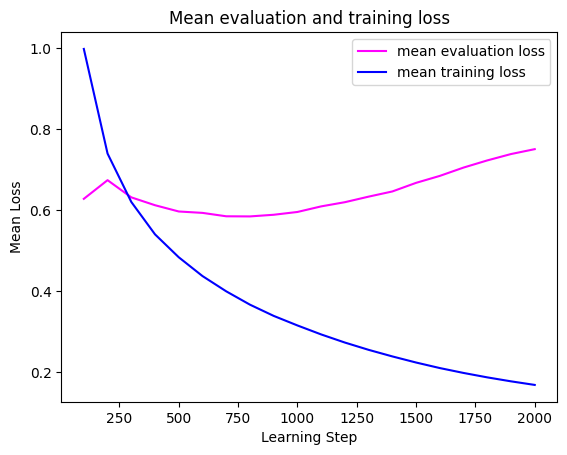

In [34]:
# TODO
training_steps = metrics_dict.keys()

mean_eval_loss = [metrics_dict[key]["mean_eval_loss"] for key in training_steps]
mean_train_loss = [metrics_dict[key]["mean_train_loss"] for key in training_steps]

sns.lineplot(x=training_steps, y=mean_eval_loss, color="magenta", label="mean evaluation loss")
sns.lineplot(x=training_steps, y=mean_train_loss, color="blue", label="mean training loss")
plt.title("Mean evaluation and training loss")
plt.xlabel("Learning Step")
plt.ylabel("Mean Loss")
plt.show()

### 12. Plot your accuracy curves

TODO: You should implement this yourself. Use the `metrics_dict` returned by the training loop.

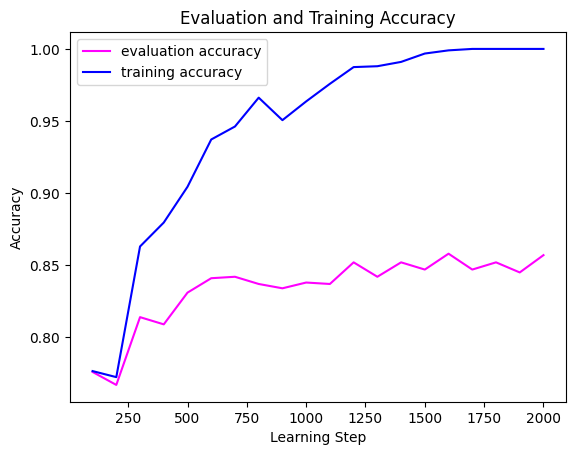

In [14]:
# TODO

training_steps = metrics_dict.keys()
eval_accuracy = [metrics_dict[key]["eval_accuracy"] for key in training_steps]
train_accuracy = [metrics_dict[key]["train_accuracy"] for key in training_steps]

sns.lineplot(x=training_steps, y=eval_accuracy, color="magenta", label="evaluation accuracy")
sns.lineplot(x=training_steps, y=train_accuracy, color="blue", label="training accuracy")
plt.title("Evaluation and Training Accuracy")
plt.xlabel("Learning Step")
plt.ylabel("Accuracy")
plt.show()

#### Descriptions of plots:

Above the evaluation and training loss and the evaluation and training accuracy respectively are plotted against the learning steps.

Regarding the loss, we can observe that the training loss is decreasing until it reaches a value of less than 0.2. It first decreases very fast and gradually decreases slowlier resulting in a less steep curve. The evaluation loss however first increases slightly, slighly decreases after that for around 400 learning steps and continues to increase after that. This is a clear sign of overfitting: the model performs well on the training data but fails to generalize well to unseen/validation data (because it rather 'memorizes' the pattern in the training data).

Overfitting can also be observed in the plot showing Evaluation and Training accuracy over learning steps. The training accuracy generally increases steadily (with one slight decrease at the ca. 800th learning step) and reaches almost a value of 100 % (or 1.0 here), while the evaluation accuracy does generally increase (with some small fluctuations) but it does not exceed an accuracy of over 0.85. Again, this indicates that the model performs well on the training data but shows a worse performance on the validation data.

Question: Based on your observations, would you recommend changing
the number of training epochs? If so, why?

To mitigate overfitting, we could reduce the number of training epochs to prevent the model from 'memorizing' the training data. We could also increase the amount of training data, use drop out regularization or try a more complex model architecture.


#### References

ChatGPT version 3.5 was used to generate code to randomly flip examples and to improve writing of original content.
